In [2]:
import gym
import itertools
import matplotlib
import numpy as np
import sklearn.pipeline
import sklearn.preprocessing

import plotting
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [3]:
env=gym.make('MountainCar-v0').env  #.env is very important otherwise the iterations will stop at 200.

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


### 1) Key points to note down regarding Mountain Car env:
1)self.min_position = -1.2

2)self.max_position = 0.6

3)self.max_speed = 0.07

4)self.goal_position = 0.5

5)self.action_space = spaces.Discrete(3)

Implies it has three actions. 

0- accelerates in the left direction
1 - zero acceleration
2- accelerates in the right direction

acceleration= 0.001 units

#### 2) Env.observation_space.sample
env.observation_space is a term defined in MountainCar.py that is  noted to Box module defined in gym library.

self.observation_space = spaces.Box(self.low, self.high)

* What Box function do is take low limit, high limit of the parameters that are defined and then the sample() function in Box module is designed to give random samples.

#### 3) sklearn.preprocessing.StandardScaler()
This function standardizes the features by removing mean and scaling to unit variance.
fit() is a method that calculates mean and variance of data provided.

* scaler.mean_ returns mean, scaler.var_ returns variance
* .fit_transform(observation_examples) does both the work of fit and transform

* scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [4]:
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
print(observation_examples)

#defining scaler as a function on which methods of StandardScaler canm be used
scaler= sklearn.preprocessing.StandardScaler()

#Calculating the mean and variance of the data: observation samples
scaler.fit(observation_examples)

normalized_data = scaler.fit_transform(observation_examples)
#print(a)
print(scaler.mean_)
print(scaler.var_)

[[-0.2121357   0.03012651]
 [-0.11502593  0.00628365]
 [-0.43742138  0.02042518]
 ...
 [ 0.51639134  0.03474443]
 [-0.66312015 -0.00749619]
 [-0.5517721   0.01762413]]
[-0.31001657 -0.0003831 ]
[0.27463287 0.00164535]


### Thorough understanding on how RBF (Radial Basis Function) kernals are used: 
What i personally think how rbf kernals are used is that RBFSampler(gamma=1,n_comnponents=100), This basically creates 100 rbf of gamma=1 => 1/variance= 1 with random centres(offsets). featurizer concatenates all of those rbfs with different gamma into a single feature vector. When samples are given , it first checks the column numbers of that mx as it defines the feature space(or the input space). The random offset is created accordingly and then, the values of rbf is given to us.

So, my obsevation says that we must get a feature vector of dimensions 400*1. And the proof for that is (featurizer.fit_transform(normalized_data)).shape give (10000,400) as output.

#### Helpful links:

https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/kernel_approximation.py

http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html

http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.normal.html

In [5]:
featurizer=sklearn.pipeline.FeatureUnion([
    ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
    ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
    ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
    ("rbf4", RBFSampler(gamma=0.5, n_components=100))
])
featurizer.fit(normalized_data)
#fit method defines the upper lower linits of random offset and fits the data.

#featurizer.fit_transform(normalized_data)
#a=featurizer.transform([normalized_data[0]])
#print(a)
#print(a[0])
#(featurizer.fit_transform(normalized_data)).shape

FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=100, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=100, random_state=None))],
       transformer_weights=None)

In [6]:
class Estimator():
    """
    Value function approximator
    """
    
    def __init__(self):
        self.models=[]
        for _ in range(env.action_space.n):
            model=SGDRegressor(learning_rate="constant", max_iter = 200000000, tol= 1e-10)
            model.partial_fit([self.featurize_state(env.reset())],[0])
            self.models.append(model)
    
    def featurize_state(self,state):
        
        scaled= scaler.transform([state])
        featurized= featurizer.transform(scaled)
        return featurized[0]
    
    def predict(self, s, a=None):
        
        feature_vec= self.featurize_state(s)
        if not a:
            return np.array([m.predict([feature_vec]) for m in self.models])
        else:
            return self.models[a].predict([feature_vec])      #.predict module is inbuilt in SGDRegresssor
    
    def update(self, s, a, y):
        
        feature_vec = self.featurize_state(s)
        (self.models[a]).partial_fit([feature_vec], [y])

In [7]:
def epsilon_greedy_policy(observation,estimator, epsilon, nA):

    A=np.ones(nA, dtype=float) * epsilon / nA
    q_values=  estimator.predict(observation)
    best_action=np.argmax(q_values)
    A[best_action] += (1.0 - epsilon)
    return A

In [8]:
def q_learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    
    stats= plotting.EpisodeStats(episode_lengths= np.zeros(num_episodes), episode_rewards = np.zeros(num_episodes))
    
    for i in range(num_episodes):
        state =env.reset()
        done= False
        
        while not done:
            
            prob = epsilon_greedy_policy(state ,estimator, epsilon * epsilon_decay**i ,env.action_space.n)
            action = np.random.choice(np.arange(len(prob)), p=prob )
            next_state, reward, done, _ = env.step(action)
            
            stats.episode_rewards[i] += reward
            stats.episode_lengths[i] += 1
            
            q_values_next = estimator.predict(next_state)
            
            td_target = reward + discount_factor * np.max(q_values_next)
            
            estimator.update(state,action,td_target)
            
            state=next_state
    
    return stats

In [9]:
estimator= Estimator()

In [10]:
stats =  q_learning(env, estimator, 100, epsilon = 0.0)

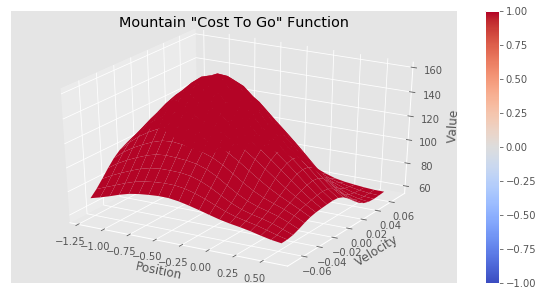

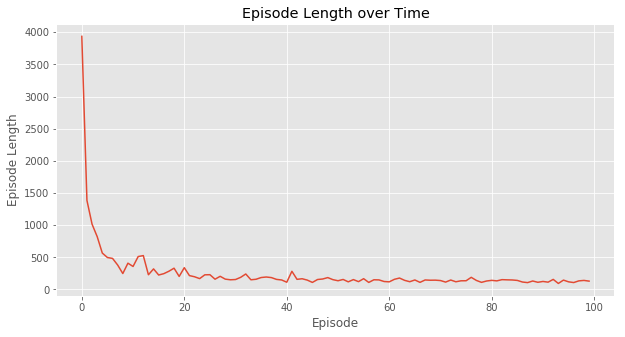

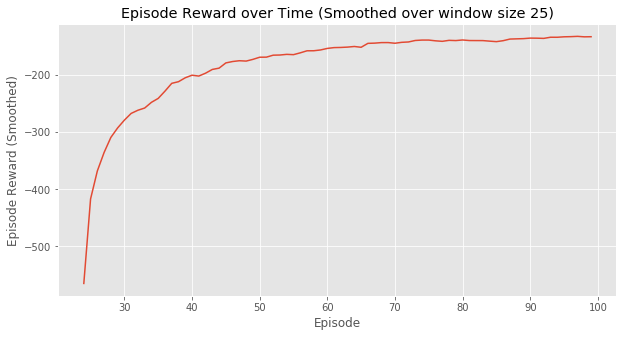

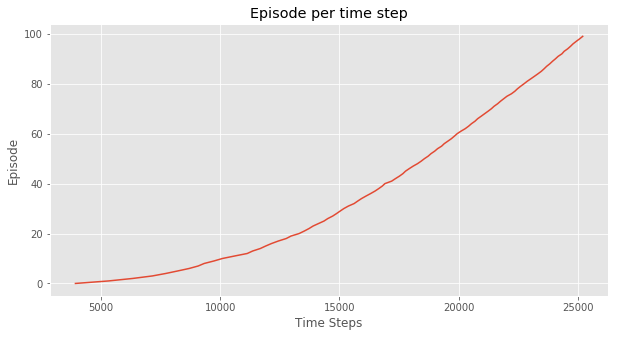

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [11]:
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)